$Q(s, a; \theta) = \mathbb{E} \left[ r_t + \gamma \max_{a'} Q(s', a'; \theta') \middle| s, a \right]$

* Q 是状态 s 和动作 a 下的 Q 值，参数 θ 表示 Q 网络的参数。
* $r_t$ 是当前步的奖励。
* $\gamma$ 是折扣因子，让未来的收益打折
* $max_{a'} Q$ 是下一步状态 $s'$中最大的 Q 值，$a'$ 是 $s'$ 中所有动作

Q 度量的是当前状态和动下下，且未来总用最优动作带来的回报折现

学习更新的方法

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right)$

## 用神经网络代替 Q

In [1]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import matplotlib.pyplot as plt
import random
from collections import deque

In [2]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 512)
        self.bn1 = nn.LayerNorm(512)  # Add BatchNorm layer
        self.dropout1 = nn.Dropout(0.2)  # Add dropout after first layer
        self.fc2 = nn.Linear(512, 512)
        self.bn2 = nn.LayerNorm(512)  # Add BatchNorm layer
        self.dropout2 = nn.Dropout(0.2)  # Add dropout after second layer
        self.fc3 = nn.Linear(512, n_actions)

        self.optimizer = optim.AdamW(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.leaky_relu(self.bn1(self.fc1(state)), negative_slope=0.01)
        layer1 = self.dropout1(layer1)
        layer2 = F.leaky_relu(self.bn2(self.fc2(layer1)), negative_slope=0.01)
        layer2 = self.dropout2(layer2)
        actions = self.fc3(layer2)
        return actions

In [3]:
class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=0.99, epsilon=1.0, ep_dec=1e-5, ep_min=0.01, mem_size=100000, batch_size=64):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = ep_dec
        self.eps_min = ep_min
        self.n_action_space = [i for i in range(n_actions)]
        self.batch_size = batch_size
        self.memory = deque(maxlen=mem_size)

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def store_transition(self, state, action, reward, state_, done):
        self.memory.append((state, action, reward, state_, done))

    def sample_memory(self):
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, states_, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(states_), np.array(dones)

    def choose_action(self, observation):
        self.Q.eval()
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float32).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.n_action_space)
        self.Q.train()
        return action
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        self.Q.optimizer.zero_grad()
        states, actions, rewards, states_, dones = self.sample_memory()

        states = T.tensor(states, dtype=T.float32).to(self.Q.device)
        actions = T.tensor(actions, dtype=T.long).to(self.Q.device)
        rewards = T.tensor(rewards, dtype=T.float32).to(self.Q.device)
        states_ = T.tensor(states_, dtype=T.float32).to(self.Q.device)
        dones = T.tensor(dones, dtype=T.bool).to(self.Q.device)

        q_pred = self.Q.forward(states)[range(self.batch_size), actions]
        q_next = self.Q.forward(states_).max(dim=1)[0]
        q_next[dones] = 0.0

        q_target = rewards + self.gamma * q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()

In [4]:
def plot_learning_curve(x, scores, eps_history, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, eps_history, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis="x", colors="C0")
    ax.tick_params(axis="y", colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("Score", color="C1")
    ax2.yaxis.set_label_position("right")
    ax2.tick_params(axis="y", colors="C1")

    # plt.savefig(filename)
    return plt

In [5]:
env = gym.make('CartPole-v1')

In [6]:
env.action_space.n

2

In [5]:
env = gym.make('CartPole-v1')
agent = Agent(input_dims=env.observation_space.shape, n_actions=env.action_space.n, lr=0.0001)
n_games = 50000
scores = []
eps_history = []

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()[0]

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, terminated, truncated, info = env.step(action)
        score += reward
        agent.store_transition(obs, action, reward, obs_, terminated or truncated)
        agent.learn()
        obs = obs_
        done = terminated or truncated

    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        if i % 1000 == 0:
            print(f'episode {i} score {score} average score {avg_score} epsilon {agent.epsilon}')

c:\Users\pangruitao\.conda\envs\py310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode 0 score 21.0 average score 21.0 epsilon 1.0
episode 1000 score 13.0 average score 26.34 epsilon 0.759610000001094
episode 2000 score 32.0 average score 46.08 epsilon 0.3892700000021648
episode 3000 score 142.0 average score 132.82 epsilon 0.01
episode 4000 score 194.0 average score 181.15 epsilon 0.01
episode 5000 score 249.0 average score 221.04 epsilon 0.01
episode 6000 score 213.0 average score 167.48 epsilon 0.01
episode 7000 score 262.0 average score 145.59 epsilon 0.01
episode 8000 score 93.0 average score 158.19 epsilon 0.01
episode 9000 score 121.0 average score 154.22 epsilon 0.01
episode 10000 score 91.0 average score 140.85 epsilon 0.01
episode 11000 score 117.0 average score 152.33 epsilon 0.01
episode 12000 score 132.0 average score 152.92 epsilon 0.01
episode 13000 score 154.0 average score 158.0 epsilon 0.01
episode 14000 score 128.0 average score 165.05 epsilon 0.01
episode 15000 score 100.0 average score 183.19 epsilon 0.01
episode 16000 score 298.0 average sco

<module 'matplotlib.pyplot' from 'c:\\Users\\pangruitao\\.conda\\envs\\py310\\lib\\site-packages\\matplotlib\\pyplot.py'>

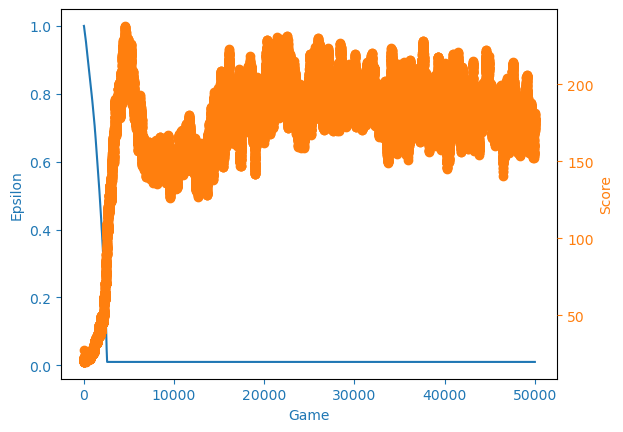

In [6]:
filename = 'cartpole_naive_dqn.png'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)